# All PyZX Features

## Contents:
* [Loading and saving circuits](#circuits)
* [Importing, exporting and editing diagrams](#diagram-io)
* [Optimizing ZX-diagrams](#optimization-zx)
* [Extracting and optimizing circuits](#optimization-circuits)
* [Phase Teleportation](#phase-teleportation)
* [Routing Circuits](#routing)

In [ ]:
import sys; sys.path.insert(0,'..')
import random, math, os
import pyzx as zx
from fractions import Fraction

<a id="circuits"></a>
# Loading and saving circuits
The most straightforward way to load a circuit is to use ``zx.Circuit.load`` which tries to figure out in which file format the circuit is given. The supported file formats are QASM, QC and the Quipper ASCII format. The corresponding loading functions are:
* ``zx.Circuit.from_qasm_file``
* ``zx.Circuit.from_quipper_file``
* ``zx.Circuit.from_qc_file``

In [ ]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname)
# Alternatively we could have done:
# circ = zx.Circuit.from_quipper_file(fname)
circ.gates

[NOT(4),
 HAD(4),
 CCZ(c1=0,c2=3,t=4),
 CCZ(c1=2,c2=3,t=4),
 HAD(4),
 CNOT(3,4),
 HAD(4),
 CCZ(c1=1,c2=2,t=4),
 HAD(4),
 CNOT(2,4),
 HAD(4),
 CCZ(c1=0,c2=1,t=4),
 HAD(4),
 CNOT(1,4),
 CNOT(0,4)]

As you can see, a circuit is essentially a list of gates (objects of type zx.circuit.Gate). We can draw the circuit using zx.draw():

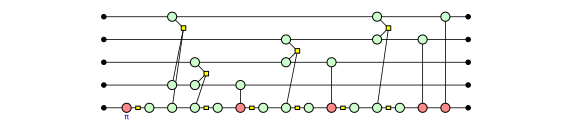

In [ ]:
zx.draw_matplotlib(circ, figsize=(10,2), h_edge_draw='box')

The CCZ gates are drawn in [ZH](https://arxiv.org/abs/1805.02175) notation by default. We can get a pure ZX-diagram if we first convert the circuit to basic (i.e. Clifford+T) gates:

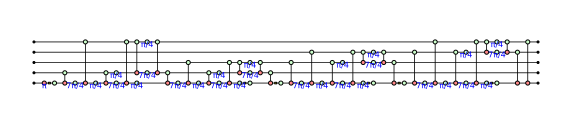

In [ ]:
zx.draw_matplotlib(circ.to_basic_gates(), figsize=(10,2), h_edge_draw='box')

Here we've drawn the circuit using the Matplotlib backend, but we can also use the D3 Javascript library to generate a more interactive representation:

In [ ]:
zx.draw(circ)

We can ask for simple statistics for this circuit:

In [ ]:
print(circ.stats())

Circuit mod5_4_before on 5 qubits with 15 gates.
        28 is the T-count
        11 Cliffords among which
        4 2-qubit gates (4 CNOT, 0 other) and
        6 Hadamard gates.
There are 4 gates of a different type


Note that a lot of the circuit is hidden in the mysterious "4 gates of a different type" (which are the CCZ gates). We can write the circuit in terms of basic gates to get more accurate Clifford+T statistics:

In [ ]:
print(circ.to_basic_gates().stats())

Circuit mod5_4_before on 5 qubits with 63 gates.
        28 is the T-count
        35 Cliffords among which
        28 2-qubit gates (28 CNOT, 0 other) and
        6 Hadamard gates.


A Circuit can be exported into the supported file formats using
    * ``circ.to_qasm``
    * ``circ.to_quipper``
    * ``circ.to_qc``

In [ ]:
print(circ.to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
x q[4];
h q[4];
ccz q[0], q[3], q[4];
ccz q[2], q[3], q[4];
h q[4];
cx q[3], q[4];
h q[4];
ccz q[1], q[2], q[4];
h q[4];
cx q[2], q[4];
h q[4];
ccz q[0], q[1], q[4];
h q[4];
cx q[1], q[4];
cx q[0], q[4];



In [ ]:
print(circ.to_quipper())

Inputs: 0:Qbit, 1:Qbit, 2:Qbit, 3:Qbit, 4:Qbit
QGate["not"](4) with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+0,+3] with nocontrol
QGate["Z"](4) with controls=[+2,+3] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+3] with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+1,+2] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+2] with nocontrol
QGate["H"](4) with nocontrol
QGate["Z"](4) with controls=[+0,+1] with nocontrol
QGate["H"](4) with nocontrol
QGate["not"](4) with controls=[+1] with nocontrol
QGate["not"](4) with controls=[+0] with nocontrol
Outputs: 0:Qbit, 1:Qbit, 2:Qbit, 3:Qbit, 4:Qbit


In [ ]:
print(circ.to_qc())

.v q0 q1 q2 q3 q4

BEGIN
X q4
H q4
Z q0 q3 q4
Z q2 q3 q4
H q4
Tof q3 q4
H q4
Z q1 q2 q4
H q4
Tof q2 q4
H q4
Z q0 q1 q4
H q4
Tof q1 q4
Tof q0 q4
END



<a id="diagram-io"></a>
# Importing, exporting and editing diagrams
PyZX also has its own json format for exporting graphs and interacts with [ZXLive](https://github.com/zxcalc/zxlive) to make manually modifying diagrams easy. First, let's see that we can indeed load diagrams:

In [ ]:
fname = os.path.join('..','circuits','2-qubit-unitary.qgraph')
with open(fname, 'r') as f:
    g = zx.Graph.from_json(f.read())
zx.draw(g, labels=True)

Because this graph was originally exported from PyZX starting as a circuit, it has automatically remembered what its inputs and outputs are:

In [ ]:
g.inputs(), g.outputs()

((9, 11, 10, 12), (10, 12, 9, 11))

For a graph that was built manually, we might need to tell it what its inputs and outputs are.

This can be done either manually:

    g.set_inputs(tuple_of_inputs); g.set_outputs(tuple_of_outputs)
    
or by PyZX through calling ``g.auto_detect_io()``. This function makes all boundaries pointing to the right inputs, and those pointing to the left inputs. For example:

In [ ]:
g.set_inputs(()) # Reset the inputs and outputs, so we can let PyZX auto-detect them
g.set_outputs(())
g.auto_detect_io()
print(g.inputs(), g.outputs())

(12, 10) (9, 11)


In [ ]:
print(g.to_json())

{"version": 2, "backend": "simple", "variable_types": {}, "scalar": {"power2": 0, "phase": "0"}, "inputs": [12, 10], "outputs": [9, 11], "vertices": [{"id": 0, "t": 2, "pos": [4, -1], "data": {"name": "v4"}}, {"id": 1, "t": 2, "pos": [3, -1], "data": {"name": "v10"}}, {"id": 2, "t": 1, "pos": [3, -2], "phase": "\u03c0/4", "data": {"name": "v11"}}, {"id": 3, "t": 1, "pos": [1, 1], "data": {"name": "v2"}}, {"id": 4, "t": 1, "pos": [1, 2], "data": {"name": "v1"}}, {"id": 5, "t": 1, "pos": [4, -2], "phase": "\u03c0/4", "data": {"name": "v5"}}, {"id": 6, "t": 2, "pos": [2, -1], "data": {"name": "v7"}}, {"id": 7, "t": 1, "pos": [4.25, 1.5], "phase": "7\u03c0/4", "data": {"name": "v9"}}, {"id": 8, "t": 1, "pos": [2, -2], "phase": "\u03c0/4", "data": {"name": "v8"}}, {"id": 9, "t": 0, "pos": [7, 1], "data": {"name": "b2"}}, {"id": 10, "t": 0, "pos": [0, 2], "data": {"name": "b8"}}, {"id": 11, "t": 0, "pos": [7, 2], "data": {"name": "b3"}}, {"id": 12, "t": 0, "pos": [0, 1], "data": {"name": "b7

We can call ZXLive from within a Jupyter notebook, in order to modify diagrams on the fly:

In [ ]:
%gui qt6

# First make sure zxlive is installed by `pip install zxlive`
from zxlive import app

g =  zx.Graph()
g.add_vertex(zx.VertexType.Z, 0, 0)
g.add_vertex(zx.VertexType.X, 0, 1)
g.add_edge((0, 1))
zx.draw(g)

zxl = app.get_embedded_app()
zxl.edit_graph(g, 'g1')
zxl.edit_graph(g, 'g2')

ERROR:root:
    Could not load requested Qt binding. Please ensure that
    PyQt4 >= 4.7, PyQt5, PyQt6, PySide >= 1.0.3, PySide2, or
    PySide6 is available, and only one is imported per session.

    Currently-imported Qt library:                              None
    PyQt5 available (requires QtCore, QtGui, QtSvg, QtWidgets): False
    PyQt6 available (requires QtCore, QtGui, QtSvg, QtWidgets): False
    PySide2 installed:                                          False
    PySide6 installed:                                          False
    Tried to load:                                              ['pyqt6']
    


ModuleNotFoundError: No module named 'zxlive'

After making some edits within ZXLive, we can get the diagram back into this window so we can continue to do further work with them:

In [ ]:
zx.draw(zxl.get_copy_of_graph('g1'))
zx.draw(zxl.get_copy_of_graph('g2'))
#Note that ZXLive only works with MultiGraph's, and hence zxl.get_copy_of_graph() always returns an instance of MultiGraph,
#and not of the default graph backend.

<a id="optimization-zx"></a>
# Optimizing ZX-diagrams
PyZX contains many functions for optimizing circuits and ZX-diagrams. In this section we will show how these methods work and can be called.

First, let us load a small circuit:

In [ ]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("original T-count:", zx.tcount(circ))
zx.draw(circ)

The most basic simplification routine for ZX-graphs is ``interior_clifford_simp``. This uses the simplification rules based on spider-fusion, identity removal, pivoting and local complementation until they cannot be applied anymore.

In [ ]:
g = circ.to_graph() # We first have to convert the circuit into a ZX-graph
zx.simplify.interior_clifford_simp(g,quiet=False) # if it is not quiet then the amount of reductions in each step is printed
# The following function makes the representation of the graph more compact.
# It only moves vertices around, and may introduce some identities
# It is recommended to call this function before trying to draw a graph, as otherwise the graph might not be very readable.
g.normalize()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

As you can see this routine has decreased the T-count by a bit, but not by a lot.


Part of the reason is that in this circuit there are still a few phaseless nodes 'trapped' in the middle of the circuit. These nodes are however connected to the boundary, so if we unfuse those boundary nodes we can get rid of the interior nodes. This can be done by calling ``zx.simplify.pivot_boundary_simp``. As this function changes the graph, we call ``interior_clifford_simp`` afterwards to do whatever new simplifications have become available.

In [ ]:
zx.simplify.pivot_boundary_simp(g, quiet=False)
zx.draw(g)
zx.simplify.interior_clifford_simp(g,quiet=False)
g.normalize()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

Though the graph is smaller now, it hasn't decreased the T-count any further in this case.

The method ``clifford_simp`` is a convenience function that calls ``interior_clifford_simp`` and ``pivot_boundary_simp`` until no further simplifications are found. It is recommended that you call ``clifford_simp`` instead of the other functions.
In order to further reduce the T-count we have to start using more advanced techniques. Namely the process of *gadgetization*:

In [ ]:
zx.simplify.pivot_gadget_simp(g, quiet=False)
zx.draw(g)
print("T-count:", zx.tcount(g))

This method combines all T-like phases with a phaseless spider to turn it into a *phase gadget*. In the previous diagram those are the spider pairs floating above the rest of the diagram, which we refer to as its *skeleton*. As you can see, the T-count has not actually been reduced by doing just these pivots, but now the graph has a completely different structure then before, so lets see what happens if we apply ``clifford_simp`` again:

In [ ]:
zx.simplify.clifford_simp(g, quiet=False)
g.normalize()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

That has reduced the T-count from 22 down to 18!

But we are in fact not done yet. If you look closely at the graph above you will see that a few of the gadgets have exactly the same set of neighbors. Whenever this happens, these phase gadgets can be fused into a single phase gadget by adding the phases together. This procedure is done by ``gadget_simp``:

In [ ]:
zx.simplify.gadget_simp(g, quiet=False)
g.normalize()
zx.draw(g)
print("Optimized T-count:", zx.tcount(g))

The T-count has now more than halved! Note that the previous best-known T-count for this circuit was 16, so this is a big improvement.

There is not much we can do now. We do one final round of ``clifford_simp`` to make the graph a bit smaller.

In [ ]:
zx.simplify.clifford_simp(g, quiet=False)
g.normalize()
zx.draw(g)

Since it is quite a bit of effort to do all these steps manually, they have been combined into the function ``full_reduce``. This procedure does the following steps:

 1. Run ``clifford_simp``.
 2. Gadgetize the diagram using ``pivot_gadget_simp``.
 4. Run ``clifford_simp``.
 5. Run ``gadget_simp``. If it finds simplifications go back to step 1, otherwise halt.

To demonstrate:

In [ ]:
g = circ.to_basic_gates().to_graph()
zx.simplify.full_reduce(g,quiet=False)
g.normalize()
zx.draw(g)

The next step is to turn this graph back into a circuit

<a id="optimization-circuits"></a>
# Extracting and optimizing circuits

For extracting circuits out of ZX-graphs there is only a single method in PyZX that you have to call: ``zx.extract_circuit``. This method should always work *when dealing with graphs produced by ``full_reduce``.* There is no guarantee that it can extract circuits from arbitrary ZX-diagrams.

Let's see what this method does when applied to the circuit from the previous section:

In [ ]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("The original circuit:")
zx.draw(circ)

g = circ.to_graph()
zx.simplify.full_reduce(g,quiet=True)
g.normalize()
print("The optimized ZX-diagram:")
zx.draw(g)

new_circ = zx.extract_circuit(g)
print("The extracted circuit:")
zx.draw(new_circ)

Explaining how ``extract_circuit`` works is out of scope for this notebook for now. If you want to know more you can check out the paper [Graph-theoretic Simplification of Quantum Circuits with the ZX-calculus](https://arxiv.org/abs/1902.03178) or the more recent (but more involved) [There and back again: A circuit extraction tale](https://arxiv.org/abs/2003.01664).

As you can see, the extracted circuit looks quite different from the original circuit, so how can we be sure that they actually represent the same unitary? PyZX allows you to convert ZX-diagrams into the tensors they represent using numpy. In this way we can directly compare the unitaries and see that they are equal:

In [ ]:
# This method checks whether the two given ZX-graphs or circuits have the same tensor representation up to some nonzero scalar
zx.compare_tensors(circ, new_circ)

This method uses ``zx.tensorfy`` under the hood to turn the circuits into tensors. This method is not optimized for memory usage, so it will run out of memory quite quickly (sometimes even for circuits with 9 or 10 qubits). It is only usable for testing small circuits and ZX-diagrams.

For larger circuits PyZX also offers a different method to check whether two circuits are equal:

In [ ]:
circ.verify_equality(new_circ)

This method takes the composition of the first circuit with the adjoint of the second and simplifies the resulting circuit with ``full_reduce``. If it succeeds, it returns ``True``, if it does not it returns ``False``. This means that if this method succeeds, that is very likely that the 2 circuits are equal (it would be very unlikely that some bug in the rewriting engine would cancel out in exactly the right way to be able to reduce the circuit to the identity). However, if it returns ``False`` it might simply mean that the rewrite engine is not powerful enough to verify the equality of the two circuits.

``extract_circuit`` often produces circuits that are clearly not optimal as can be seen in the series of Hadamard gates at the end of the above extracted circuit. PyZX offers a circuit optimization method that takes care of this obvious kind of suboptimality:

In [ ]:
print(new_circ.to_basic_gates().stats())
optimized_circ = zx.optimize.basic_optimization(new_circ.to_basic_gates(),do_swaps=False).to_basic_gates()
print(optimized_circ.stats())
zx.draw(optimized_circ)

``basic_optimization`` commutes gates past Hadamards in order to find matching CNOT, CZ and Hadamard gates that can be cancelled. Depending on the circuit it can find significant reductions in the amount of Hadamard gates, which is useful for the next optimization routine. Note that we gave it the argument `do_swaps=False`. When this is instead set to True, it employs more powerful optimization techniques involving transforming adjacent CNOT gates into SWAPs. While for larger circuits this often leads to better results, for the above circuit it actually increases the 2-qubit gate-count (from 25 to 27).

As you can see, the optimized circuit only contains 2 Hadamard gates, and in fact the leftmost Hadamard gate could be commuted past the CNOTs and CZs to its left so that the entire interior of the circuit is free of Hadamards. Such a Hadamard-free circuit is called a *phase polynomial* circuit, and there are specific techniques for optimizing these types of circuits. PyZX offers a method that finds phase polynomial sub-circuits and runs an optimization routine on them:

In [ ]:
final_circ = zx.optimize.phase_block_optimize(optimized_circ).to_basic_gates()
final_circ = zx.optimize.basic_optimization(final_circ) # We call this again, as it does some extra processing
print(final_circ.stats())
zx.draw(final_circ)

Let's check once more that this circuit is still equal to the original circuit:

In [ ]:
zx.compare_tensors(circ, final_circ)

And finally lets output this circuit in a format that is usable in other software:

In [ ]:
print(final_circ.to_qasm())

<a id="phase-teleportation"></a>
# Phase teleportation

The above procedure of simplifying a diagram, and extracting a new circuit directly from it worked quite well in the example given above, but unfortunately in other cases it can actually *increase* the total gate-count (although it never increases the amount of T-gates).

To get around this issue PyZX offers the *phase teleportation* routine. This uses the diagrammatic simplification only as information to inform when phase gates can be combined in the original circuit, but otherwise it leaves the circuit intact. The details can be found in [Reducing T-count with the ZX-calculus](https://arxiv.org/abs/1903.10477).

In [ ]:
fname = os.path.join('..','circuits','Fast', 'mod5_4_before')
circ = zx.Circuit.load(fname).to_basic_gates()
print("The original circuit:")
zx.draw(circ)
g = zx.simplify.teleport_reduce(circ.to_graph(),quiet=True)
print("Circuit after phase teleportation:")
zx.draw(g)

As you can see the circuit is exactly the same, except that it has less phase gates. Let's verify that it is indeed still the same circuit:

In [ ]:
zx.compare_tensors(circ, g)

<a id="routing"></a>
# Routing Quantum Circuits

This section demonstrates how to route quantum circuits to specific hardware architectures using PyZX.  

Routing transforms a logical circuit, which may contain long-range gates not directly supported by hardware, into an equivalent circuit that respects the connectivity constraints of the target architecture.

We show how to route a 5-qubit circuit to:
- A linear (line) architecture
- The IBM QX4 quantum processor

The routing uses the Gray synthesis method and optionally the Gray-Meijer combined method for more constrained layouts.


In [ ]:
from fractions import Fraction
import pyzx as zx
from pyzx.routing import create_architecture, route_phase_poly, RoutingMethod, ElimMode

# Create a logical circuit to route
circ = zx.Circuit(5)
circ.add_gate("CNOT", 0, 4)
circ.add_gate("CNOT", 1, 3)
circ.add_gate("CNOT", 4, 2)
circ.add_gate("CNOT", 2, 0)
circ.add_gate("CNOT", 3, 1)
circ.add_gate("CNOT", 0, 1)
circ.add_gate("ZPhase", 0, Fraction(1, 4))
circ.add_gate("ZPhase", 2, Fraction(1, 2))
circ.add_gate("ZPhase", 3, Fraction(3, 4))
circ.add_gate("ZPhase", 4, Fraction(1, 8))

# Define architectures
line_arch = create_architecture('line', n_qubits=5)
ibm_arch = create_architecture('ibm_qx4')

# Route the circuit
routed_line = route_phase_poly(circ, line_arch, method=RoutingMethod.GRAY, mode=ElimMode.STEINER_MODE)
routed_ibm = route_phase_poly(circ, ibm_arch, method=RoutingMethod.GRAY_MEIJER, mode=ElimMode.STEINER_MODE)

# Print stats
print("Original Circuit Stats:")
print(circ.stats())
print("\nRouted on Line Architecture:")
print(routed_line.stats())
print("\nRouted on IBM QX4 Architecture:")
print(routed_ibm.stats())



Original Circuit Stats:
Circuit  on 5 qubits with 10 gates.
        3 is the T-count
        7 Cliffords among which
        6 2-qubit gates (6 CNOT, 0 other) and
        0 Hadamard gates.

Routed on Line Architecture:
Circuit  on 5 qubits with 46 gates.
        3 is the T-count
        43 Cliffords among which
        42 2-qubit gates (42 CNOT, 0 other) and
        0 Hadamard gates.

Routed on IBM QX4 Architecture:
Circuit  on 5 qubits with 28 gates.
        3 is the T-count
        25 Cliffords among which
        24 2-qubit gates (24 CNOT, 0 other) and
        0 Hadamard gates.


## 3. Classical Control in Hybrid Circuits
# 3.1 Classical Data as Control Flow
In hybrid circuits, classical bits can control quantum gates (e.g., "apply X if measurement result is 1").

In ZX terms, this is modeled by:

Adding auxiliary spiders representing classical bits.

Connecting them to quantum operation spiders to simulate conditional behavior.

This does not yet reflect true conditional unitary logic but mimics classical correlations through graph topology:

$[
\text{Classical control} \Rightarrow \text{Modified connectivity and phase of spiders}
]$



Added 2 classical control vertices


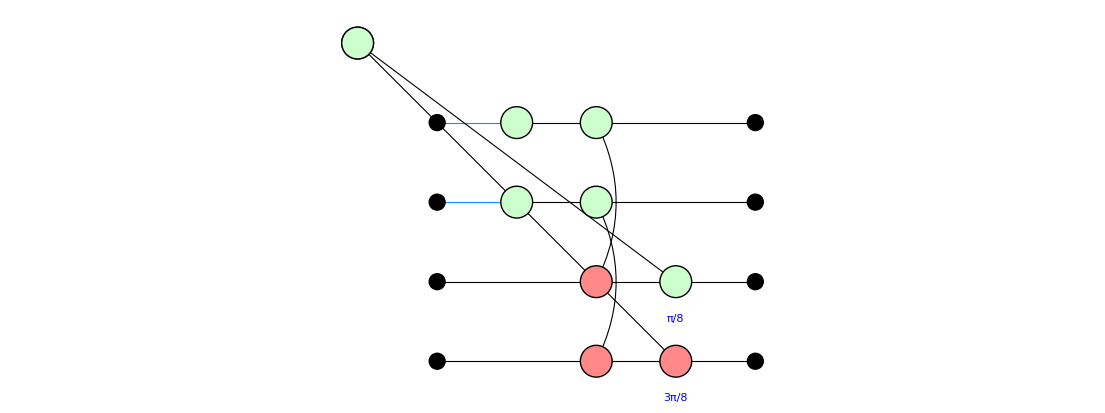

In [3]:
def create_classically_controlled_circuit():
    """Create a circuit with classical control flow"""
    circ = zx.Circuit(4)

    # Prepare some initial states
    circ.add_gate("H", 0)
    circ.add_gate("H", 1)

    # Create entanglement
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    # Add conditional operations (simulated through graph structure)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))
    circ.add_gate("XPhase", 3, Fraction(3, 8))

    return circ

controlled_circ = create_classically_controlled_circuit()

# Convert to graph and add classical control structure
def add_classical_control(g):
    """Add classical control structure to a ZX graph"""
    # This simulates classical control by adding conditional structure
    # In practice, this would involve more complex graph modifications

    # Add auxiliary vertices to represent classical bits
    classical_vertices = []
    for i in range(2):
        classical_v = g.add_vertex(zx.VertexType.Z, phase=0)
        classical_vertices.append(classical_v)

    # Connect classical control to quantum operations
    quantum_vertices = [v for v in g.vertices() if g.phase(v) != 0]

    for i, qv in enumerate(quantum_vertices[:2]):
        if i < len(classical_vertices):
            # This represents classical control dependency
            g.add_edge((classical_vertices[i], qv))

    return g, classical_vertices

controlled_g = controlled_circ.to_graph()
controlled_g, classical_vs = add_classical_control(controlled_g)

print(f"Added {len(classical_vs)} classical control vertices")
zx.draw_matplotlib(controlled_g, figsize=(14, 5))

## ZX Optimization and Graph Simplification
# Full Reduce Algorithm
ZX diagrams are manipulated by equational rewrite rules:

Spider fusion: Two Z-spiders connected directly can be merged.

Bialgebra rule: Governs interactions between Z and X spiders.

Hopf law: Simplifies entangled structures.

Pi-copy: Allows propagation of
$[
\pi
]$
phase through spiders.

Optimization uses these rules to:

Reduce number of vertices/edges.

Find circuit equivalents with fewer gates.

Identify classical subgraphs: parts of the diagram that behave deterministically and could be classically simulated.

Mathematically, this is graph rewriting in a monoidal category, preserving the linear map semantics.

Before optimization:
Original graph stats:
  Vertices: 27
  Edges: 26
After standard optimization:
  Vertices: 18
  Edges: 17

After optimization:


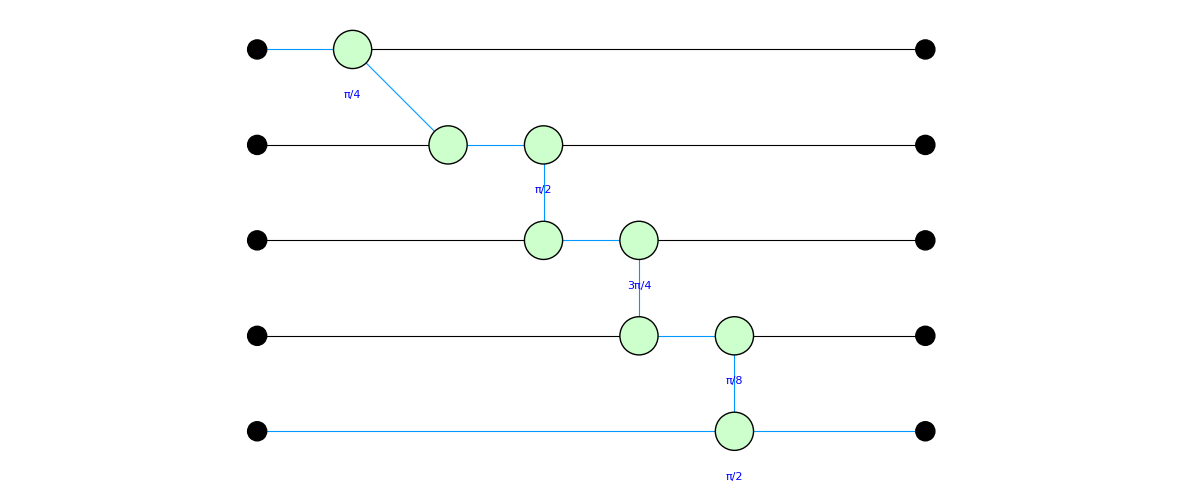

In [4]:
def optimize_hybrid_circuit(g):
    """Apply optimization rules for hybrid circuits"""
    print("Original graph stats:")
    print(f"  Vertices: {g.num_vertices()}")
    print(f"  Edges: {g.num_edges()}")

    # Apply standard ZX optimizations
    zx.simplify.full_reduce(g)

    print("After standard optimization:")
    print(f"  Vertices: {g.num_vertices()}")
    print(f"  Edges: {g.num_edges()}")

    return g

# Create a more complex circuit for optimization
def create_complex_hybrid_circuit():
    """Create a complex circuit with classical and quantum parts"""
    circ = zx.Circuit(5)

    # Quantum part
    for i in range(4):
        circ.add_gate("H", i)

    # Create entanglement chain
    for i in range(4):
        circ.add_gate("CNOT", i, (i+1) % 5)

    # Add various phase gates
    phases = [Fraction(1, 4), Fraction(1, 2), Fraction(3, 4), Fraction(1, 8)]
    for i, phase in enumerate(phases):
        circ.add_gate("ZPhase", i, phase)

    # Add some X rotations
    circ.add_gate("XPhase", 4, Fraction(1, 2))

    return circ

complex_circ = create_complex_hybrid_circuit()
complex_g = complex_circ.to_graph()

print("Before optimization:")
zx.draw_matplotlib(complex_g, figsize=(15, 6))

# Optimize
optimized_g = optimize_hybrid_circuit(complex_g.copy())

print("\nAfter optimization:")
zx.draw_matplotlib(optimized_g, figsize=(15, 6))

Added 2 classical control vertices


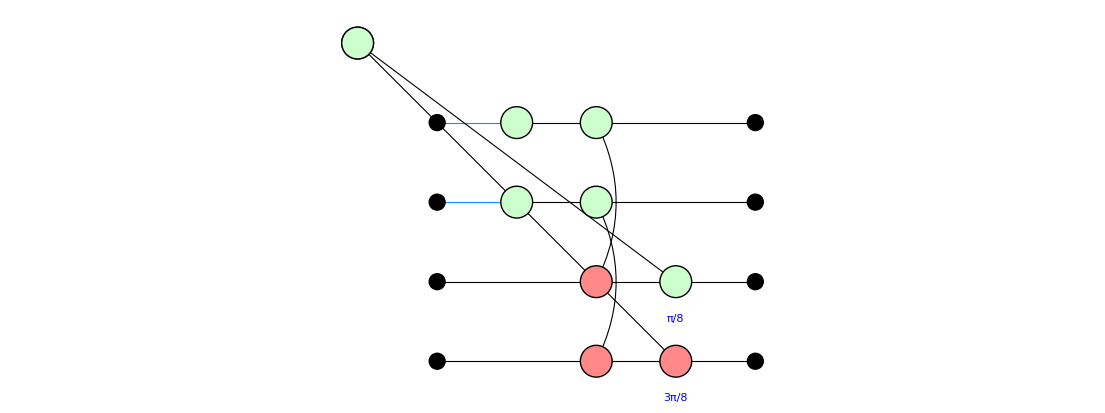

In [5]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def create_classically_controlled_circuit():
    """Create a circuit with classical control flow"""
    circ = zx.Circuit(4)

    # Prepare some initial states
    circ.add_gate("H", 0)
    circ.add_gate("H", 1)

    # Create entanglement
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    # Add conditional operations (simulated through graph structure)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))
    circ.add_gate("XPhase", 3, Fraction(3, 8))

    return circ

controlled_circ = create_classically_controlled_circuit()

# Convert to graph and add classical control structure
def add_classical_control(g):
    """Add classical control structure to a ZX graph"""
    # This simulates classical control by adding conditional structure
    # In practice, this would involve more complex graph modifications

    # Add auxiliary vertices to represent classical bits
    classical_vertices = []
    for i in range(2):
        classical_v = g.add_vertex(zx.VertexType.Z, phase=0)
        classical_vertices.append(classical_v)

    # Connect classical control to quantum operations
    quantum_vertices = [v for v in g.vertices() if g.phase(v) != 0]

    for i, qv in enumerate(quantum_vertices[:2]):
        if i < len(classical_vertices):
            # This represents classical control dependency
            g.add_edge((classical_vertices[i], qv))

    return g, classical_vertices

controlled_g = controlled_circ.to_graph()
controlled_g, classical_vs = add_classical_control(controlled_g)

print(f"Added {len(classical_vs)} classical control vertices")
zx.draw_matplotlib(controlled_g, figsize=(14, 5))


Potentially classical vertices: 11
Quantum vertices: 5
Circuit analysis complete:
- Classical-like vertices: 11
- Quantum vertices: 5
(Note: This is a simplified heuristic classification)

Detailed vertex analysis:
Vertex 0: Type=0, Phase=0, Degree=1, Class=Classical-like
Vertex 1: Type=0, Phase=0, Degree=1, Class=Classical-like
Vertex 2: Type=0, Phase=0, Degree=1, Class=Classical-like
Vertex 3: Type=0, Phase=0, Degree=1, Class=Classical-like
Vertex 4: Type=2, Phase=1, Degree=2, Class=Classical-like
Vertex 5: Type=1, Phase=1, Degree=2, Class=Classical-like
Vertex 6: Type=1, Phase=0, Degree=2, Class=Classical-like
Vertex 7: Type=1, Phase=1/8, Degree=2, Class=Quantum
Vertex 8: Type=2, Phase=0, Degree=3, Class=Quantum
Vertex 9: Type=1, Phase=0, Degree=3, Class=Quantum


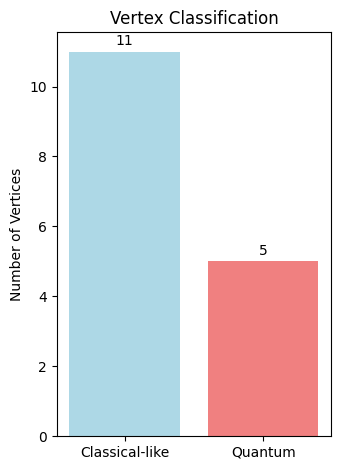


Vertex type distribution:
Types: {'0': 8, '2': 3, '1': 5}
Phases: {0: 13, Fraction(1, 1): 2, Fraction(1, 8): 1}


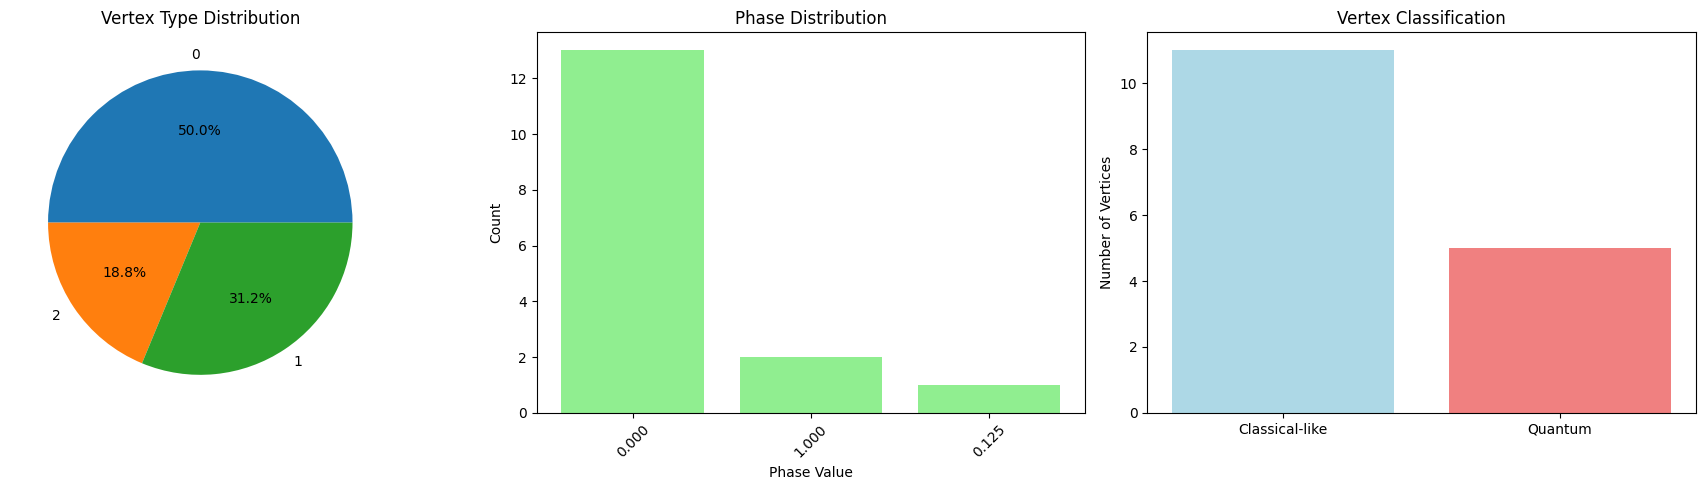

In [6]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def analyze_classical_components(g):
    """Analyze which parts of a circuit can be implemented classically"""

    # This is a simplified version of the classicalization algorithm
    # from the paper

    classical_vertices = []
    quantum_vertices = []

    for v in g.vertices():
        vertex_type = g.type(v)
        phase = g.phase(v)

        # Fix: Use len(g.neighbors(v)) to get degree instead of g.degree(v)
        try:
            degree = len(list(g.neighbors(v)))
        except:
            # Fallback: count edges connected to this vertex
            degree = len([e for e in g.edges() if v in e])

        # Heuristic: vertices with specific phases and connections
        # might be implementable classically
        if phase in [0, Fraction(1, 1)] and degree <= 2:
            classical_vertices.append(v)
        else:
            quantum_vertices.append(v)

    print(f"Potentially classical vertices: {len(classical_vertices)}")
    print(f"Quantum vertices: {len(quantum_vertices)}")

    return classical_vertices, quantum_vertices

# Create a mixed circuit
def create_mixed_classical_quantum():
    """Create a circuit with both classical and quantum parts"""
    circ = zx.Circuit(4)

    # Classical-like operations (Pauli gates as phase rotations)
    circ.add_gate("XPhase", 0, Fraction(1, 1))  # X gate = π rotation around X
    circ.add_gate("ZPhase", 1, Fraction(1, 1))  # Z gate = π rotation around Z

    # Quantum operations
    circ.add_gate("H", 2)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))  # T gate

    # Mixed operations
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    return circ

# Create the circuit and convert to graph
mixed_circ = create_mixed_classical_quantum()
mixed_g = mixed_circ.to_graph()

# Plot only using zx.draw_matplotlib
zx.draw_matplotlib(mixed_g, figsize=(12, 6))



# Analyze components
classical_vs, quantum_vs = analyze_classical_components(mixed_g)

print(f"Circuit analysis complete:")
print(f"- Classical-like vertices: {len(classical_vs)}")
print(f"- Quantum vertices: {len(quantum_vs)}")
print("(Note: This is a simplified heuristic classification)")

# Print detailed analysis of each vertex
print("\nDetailed vertex analysis:")
for i, v in enumerate(list(mixed_g.vertices())[:10]):  # Show first 10 vertices
    vertex_type = mixed_g.type(v)
    phase = mixed_g.phase(v)
    try:
        neighbors = list(mixed_g.neighbors(v))
        degree = len(neighbors)
    except:
        degree = "unknown"

    classification = "Classical-like" if v in classical_vs else "Quantum"
    print(f"Vertex {v}: Type={vertex_type}, Phase={phase}, Degree={degree}, Class={classification}")


zx.draw_matplotlib(mixed_g, figsize=(6, 4))


plt.subplot(1, 2, 2)
# Create a simple bar chart of the analysis
categories = ['Classical-like', 'Quantum']
counts = [len(classical_vs), len(quantum_vs)]
plt.bar(categories, counts, color=['lightblue', 'lightcoral'])
plt.title('Vertex Classification')
plt.ylabel('Number of Vertices')

# Add count labels on bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Additional analysis: examine vertex types and phases
print("\nVertex type distribution:")
vertex_types = {}
vertex_phases = {}

for v in mixed_g.vertices():
    vtype = str(mixed_g.type(v))
    phase = mixed_g.phase(v)

    if vtype not in vertex_types:
        vertex_types[vtype] = 0
    vertex_types[vtype] += 1

    if phase not in vertex_phases:
        vertex_phases[phase] = 0
    vertex_phases[phase] += 1

print("Types:", vertex_types)
print("Phases:", vertex_phases)

# Create additional visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Vertex types
ax1 = axes[0]
if vertex_types:
    ax1.pie(vertex_types.values(), labels=vertex_types.keys(), autopct='%1.1f%%')
    ax1.set_title('Vertex Type Distribution')

# Phase distribution
ax2 = axes[1]
if vertex_phases:
    phases_str = [f"{float(p):.3f}" for p in vertex_phases.keys()]
    ax2.bar(phases_str, vertex_phases.values(), color='lightgreen')
    ax2.set_title('Phase Distribution')
    ax2.set_xlabel('Phase Value')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

# Classification comparison
ax3 = axes[2]
ax3.bar(['Classical-like', 'Quantum'], [len(classical_vs), len(quantum_vs)],
        color=['lightblue', 'lightcoral'])
ax3.set_title('Vertex Classification')
ax3.set_ylabel('Number of Vertices')

plt.tight_layout()
plt.show()

## Construction of a Mixed Classical-Quantum Circuit
1.1 Circuit Initialization
Create a quantum circuit on
$[ n = 4 ]$
qubits:

$[
\text{circ} = \text{zx.Circuit}(4)
]$

1.2 Adding Classical-like Gates
Add gates representing classical Pauli operations expressed as phase rotations:

XPhase gate on qubit 0 with phase
$[ \pi ]$ (represented as fraction $[ \frac{1}{1} ]$):

$[
XPhase(0, \pi)
]$

ZPhase gate on qubit 1 with phase
$[ \pi ]$:

$[
ZPhase(1, \pi)
]$

These correspond to the Pauli-X and Pauli-Z gates, which can be represented as rotations of angle $\pi$ around respective axes.

1.3 Adding Quantum Gates
Add the Hadamard gate on qubit 2:

$[
H(2)
]$

Add the T gate (a $\frac{\pi}{4}$ phase rotation) on qubit 2, represented as:

$[
ZPhase(2, \frac{\pi}{8})
]$

The T gate introduces a non-Clifford phase, providing universal quantum computational power.

1.4 Adding Entangling Gates
Add two CNOT gates (controlled-NOT):

Control qubit 0, target qubit 2:

$[
\text{CNOT}(0, 2)
]$

Control qubit 1, target qubit 3:

$[
\text{CNOT}(1, 3)
]$

These gates create entanglement between qubits, mixing classical and quantum parts.

1.5 Return the Constructed Circuit
The function outputs the complete mixed circuit:

$[
\text{return } \text{circ}
]$

2. Conversion of Circuit to ZX Graph
Convert the circuit into a ZX-diagram graph representation:

$[
G = \text{circ.to_graph}()
]$

This graph captures the circuit’s operations as vertices (spiders) and edges (wires).

3. Visualization
Draw the ZX graph using matplotlib via PyZX’s built-in function:

$[
\text{zx.draw_matplotlib}(G, \text{figsize} = (12, 6))
]$

This produces a graphical representation of the ZX diagram, showing the topology and phases of spiders.

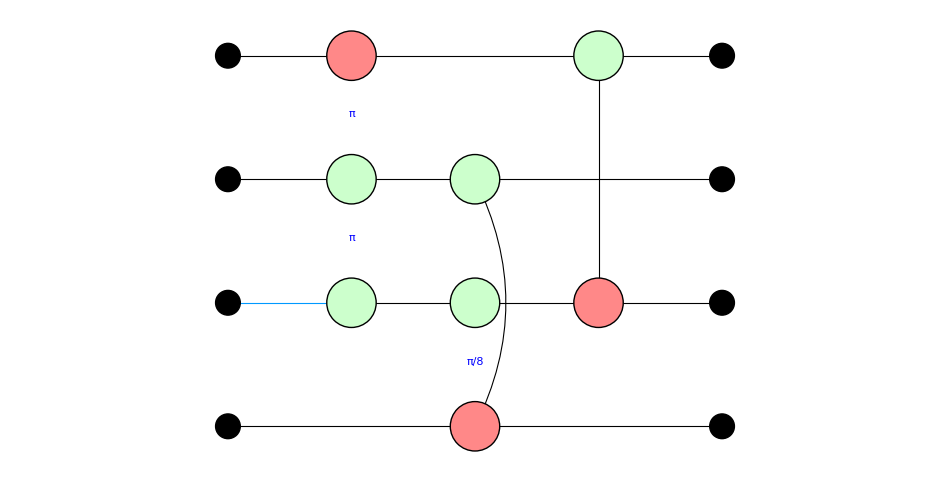

In [7]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

# Create a mixed circuit
def create_mixed_classical_quantum():
    """Create a circuit with both classical and quantum parts"""
    circ = zx.Circuit(4)

    # Classical-like operations (Pauli gates as phase rotations)
    circ.add_gate("XPhase", 0, Fraction(1, 1))  # X gate = π rotation around X
    circ.add_gate("ZPhase", 1, Fraction(1, 1))  # Z gate = π rotation around Z

    # Quantum operations
    circ.add_gate("H", 2)
    circ.add_gate("ZPhase", 2, Fraction(1, 8))  # T gate

    # Mixed operations
    circ.add_gate("CNOT", 0, 2)
    circ.add_gate("CNOT", 1, 3)

    return circ

# Create the circuit and convert to graph
mixed_circ = create_mixed_classical_quantum()
mixed_g = mixed_circ.to_graph()

# Plot only using zx.draw_matplotlib
zx.draw_matplotlib(mixed_g, figsize=(12, 6))

## Benchmarking Optimization on Quantum Circuits
# 1.1 Setup and Data Structure
Initialize an empty dictionary to store optimization results:

$[
\text{results} = {}
]$

1.2 Pure Quantum Circuit Construction
Create a circuit with
$[n = 4]$
qubits:

$[
\text{pure_circ} = \text{zx.Circuit}(4)
]$

Apply Hadamard gates on all qubits:

$[
\forall i \in {0,1,2,3}, \quad H_i
]$

Apply a chain of CNOT gates linking qubits:

$[
\text{CNOT}_{i,i+1} \quad \text{for} \quad i = 0,1,2
]$

Apply phase rotations about Z with phase
$[ \frac{\pi}{4} ]$
on all qubits:

$[
ZPhase_i\left(\frac{\pi}{4}\right), \quad \forall i \in {0,1,2,3}
]$

Convert the circuit to a ZX graph:

$[
pure_g = pure_circ.to_graph()
]$

Measure the original number of vertices (spiders):

$[
V_{\text{original}} = pure_g.num_vertices()
]$

1.3 Optimization of Pure Quantum Graph
Create a copy to preserve original graph:

$[
pure_g_{copy} = pure_g.copy()
]$

Apply the full ZX-calculus reduction/simplification procedure:

$[
\text{zx.simplify.full_reduce}(pure_g_{copy})
]$

Record the optimized number of vertices:

$[
V_{\text{optimized}} = pure_g_{copy}.num_vertices()
]$

Calculate reduction:

$[
R = V_{\text{original}} - V_{\text{optimized}}
]$

Store results in dictionary:

$[
\text{results}['pure_quantum'] = {
\text{'original'}: V_{\text{original}}, ,
\text{'optimized'}: V_{\text{optimized}}, ,
\text{'reduction'}: R
}
]$

1.4 Hybrid Circuit Construction
Initialize a 4-qubit circuit:

$[
\text{hybrid_circ} = \text{zx.Circuit}(4)
]$

Apply Hadamard gates on all qubits:

$[
\forall i \in {0,1,2,3}, \quad H_i
]$

Apply CNOT gates linking adjacent qubits:

$[
\text{CNOT}_{i,i+1} \quad \text{for} \quad i = 0,1,2
]$

Convert to ZX graph:

$[
hybrid_g = hybrid_circ.to_graph()
]$

Get output vertices of the graph (note: method call):

$[
outputs = hybrid_g.outputs()
]$

Add “ground” vertices to simulate measurements (Z-spiders with zero phase):

For $[ i = 0, 1 ]$:

$[
g_i = \text{hybrid_g.add_vertex}(\text{ZX.VertexType.Z}, , \text{phase}=0)
]$

Connect output vertices to ground vertices:

$[
\text{hybrid_g.add_edge} \bigl( (outputs[i], g_i) \bigr)
]$

1.5 Optimization of Hybrid Graph
Record original number of vertices:

$[
V_{\text{original, hybrid}} = hybrid_g.num_vertices()
]$

Copy graph to preserve original:

$[
hybrid_g_{copy} = hybrid_g.copy()
]$

Simplify copied graph:

$[
\text{zx.simplify.full_reduce}(hybrid_g_{copy})
]$

Record optimized number of vertices:

$[
V_{\text{optimized, hybrid}} = hybrid_g_{copy}.num_vertices()
]$

Compute reduction:

$[
R_{\text{hybrid}} = V_{\text{original, hybrid}} - V_{\text{optimized, hybrid}}
]$

Store hybrid results:

$[
\text{results}['hybrid'] = {
\text{'original'}: V_{\text{original, hybrid}}, ,
\text{'optimized'}: V_{\text{optimized, hybrid}}, ,
\text{'reduction'}: R_{\text{hybrid}}
}
]$

1.6 Return Benchmark Results
Return the results dictionary containing both circuit analyses:

$[
\text{return results}
]$

2. Output and Visualization
2.1 Console Output
Print formatted results for each circuit type:

For each $[ c \in {\text{pure_quantum}, \text{hybrid}} ]$:

$[
\begin{cases}
\text{Original vertices: } V_{\text{original}} \
\text{Optimized vertices: } V_{\text{optimized}} \
\text{Reduction: } R = V_{\text{original}} - V_{\text{optimized}} \
\text{Reduction percentage: } \frac{R}{V_{\text{original}}} \times 100 %
\end{cases}
]$

Optimization Benchmark Results:
PURE_QUANTUM:
  Original vertices: 22
  Optimized vertices: 15
  Reduction: 7
  Reduction %: 31.8%

HYBRID:
  Original vertices: 20
  Optimized vertices: 16
  Reduction: 4
  Reduction %: 20.0%



<ipython-input-8-c2d9b0c2d10e>:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([ct.replace('_', ' ').title() for ct in circuit_types])


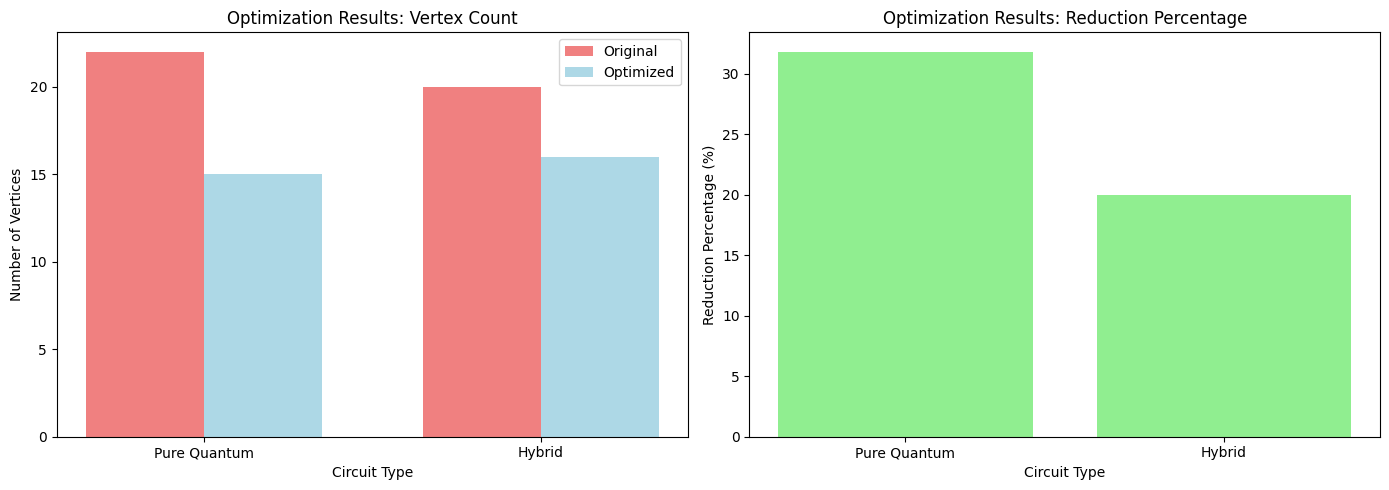

In [8]:
import pyzx as zx
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

def benchmark_optimization():
    """Benchmark optimization on different circuit types"""

    results = {}

    # Pure quantum circuit
    pure_circ = zx.Circuit(4)
    for i in range(4):
        pure_circ.add_gate("H", i)
    for i in range(3):
        pure_circ.add_gate("CNOT", i, i+1)
    for i in range(4):
        pure_circ.add_gate("ZPhase", i, Fraction(1, 4))

    pure_g = pure_circ.to_graph()
    original_vertices = pure_g.num_vertices()

    # Optimize (work on a copy)
    pure_g_copy = pure_g.copy()
    zx.simplify.full_reduce(pure_g_copy)
    optimized_vertices = pure_g_copy.num_vertices()

    results['pure_quantum'] = {
        'original': original_vertices,
        'optimized': optimized_vertices,
        'reduction': original_vertices - optimized_vertices
    }

    # Hybrid circuit (with measurements)
    hybrid_circ = zx.Circuit(4)
    for i in range(4):
        hybrid_circ.add_gate("H", i)
    for i in range(3):
        hybrid_circ.add_gate("CNOT", i, i+1)

    hybrid_g = hybrid_circ.to_graph()

    # Fix: g.outputs is a method, need to call it
    outputs = hybrid_g.outputs()

    # Add ground generators for measurements
    for i in range(2):
        ground_v = hybrid_g.add_vertex(zx.VertexType.Z, phase=0)
        if i < len(outputs):
            hybrid_g.add_edge((outputs[i], ground_v))

    original_vertices_hybrid = hybrid_g.num_vertices()

    # Optimize (work on a copy)
    hybrid_g_copy = hybrid_g.copy()
    zx.simplify.full_reduce(hybrid_g_copy)
    optimized_vertices_hybrid = hybrid_g_copy.num_vertices()

    results['hybrid'] = {
        'original': original_vertices_hybrid,
        'optimized': optimized_vertices_hybrid,
        'reduction': original_vertices_hybrid - optimized_vertices_hybrid
    }

    return results

benchmark_results = benchmark_optimization()

print("Optimization Benchmark Results:")
print("=" * 40)
for circuit_type, data in benchmark_results.items():
    print(f"{circuit_type.upper()}:")
    print(f"  Original vertices: {data['original']}")
    print(f"  Optimized vertices: {data['optimized']}")
    print(f"  Reduction: {data['reduction']}")
    if data['original'] > 0:
        print(f"  Reduction %: {100 * data['reduction'] / data['original']:.1f}%")
    else:
        print(f"  Reduction %: 0.0%")
    print()

# Create a visualization of the benchmark results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of vertex counts
circuit_types = list(benchmark_results.keys())
original_counts = [benchmark_results[ct]['original'] for ct in circuit_types]
optimized_counts = [benchmark_results[ct]['optimized'] for ct in circuit_types]

x = range(len(circuit_types))
width = 0.35

ax1.bar([i - width/2 for i in x], original_counts, width, label='Original', color='lightcoral')
ax1.bar([i + width/2 for i in x], optimized_counts, width, label='Optimized', color='lightblue')
ax1.set_xlabel('Circuit Type')
ax1.set_ylabel('Number of Vertices')
ax1.set_title('Optimization Results: Vertex Count')
ax1.set_xticks(x)
ax1.set_xticklabels([ct.replace('_', ' ').title() for ct in circuit_types])
ax1.legend()

# Reduction percentages
reductions = [100 * benchmark_results[ct]['reduction'] / benchmark_results[ct]['original']
              if benchmark_results[ct]['original'] > 0 else 0
              for ct in circuit_types]

ax2.bar(circuit_types, reductions, color='lightgreen')
ax2.set_xlabel('Circuit Type')
ax2.set_ylabel('Reduction Percentage (%)')
ax2.set_title('Optimization Results: Reduction Percentage')
ax2.set_xticklabels([ct.replace('_', ' ').title() for ct in circuit_types])

plt.tight_layout()
plt.show()